## This notebook is built from the combined dataset that Lawrence has assembled and supplements Danny's EDA.

### Imports and Useful Constants

In [30]:
import pickle
import numpy as np
import pandas as pd

filename = "../../datasets/acousticbrainz_all_flattened_labeled.pickle.bz2"

base_genres = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock",
]

subgenres = [
    "genre_orchestral",
    "genre_poprock",
    "genre_instrumentalpop",
    "genre_rap",
    "genre_punkrock",
    "genre_symphonic",
    "genre_instrumentalrock",
    "genre_hardrock",
    "genre_grunge",
    "genre_rocknroll",
    "genre_acidjazz",
    "genre_heavymetal",
    "genre_classicrock",
    "genre_jazzfusion",
    "genre_alternativerock",
]

unidentified_genres = [
    "genre_alternative",
    "genre_dance",
    "genre_indie",
    "genre_folk",
    "genre_popfolk",
    "genre_triphop",
    "genre_funk",
    "genre_rnb",
    "genre_soul",
    "genre_ska",
    "genre_groove",
    "genre_jazzfunk",
    "genre_swing",
    "genre_bossanova",
    "genre_bluesrock",
]

### Load dataset and confirm shape

In [2]:
df = pd.read_pickle(filename)
df.shape

(55213, 2877)

### Remove features since we are only looking at labels in this notebook

In [3]:
df = df.filter(regex="^genre")
df.shape

(55213, 95)

In [4]:
df.columns

Index(['genre_60s', 'genre_70s', 'genre_80s', 'genre_90s', 'genre_acidjazz',
       'genre_african', 'genre_alternative', 'genre_alternativerock',
       'genre_ambient', 'genre_atmospheric', 'genre_blues', 'genre_bluesrock',
       'genre_bossanova', 'genre_breakbeat', 'genre_celtic', 'genre_chanson',
       'genre_chillout', 'genre_choir', 'genre_classical', 'genre_classicrock',
       'genre_club', 'genre_contemporary', 'genre_country', 'genre_dance',
       'genre_darkambient', 'genre_darkwave', 'genre_deephouse', 'genre_disco',
       'genre_downtempo', 'genre_drumnbass', 'genre_dub', 'genre_dubstep',
       'genre_easylistening', 'genre_edm', 'genre_electronic',
       'genre_electronica', 'genre_electropop', 'genre_ethnicrock',
       'genre_ethno', 'genre_eurodance', 'genre_experimental', 'genre_folk',
       'genre_funk', 'genre_fusion', 'genre_gothic', 'genre_groove',
       'genre_grunge', 'genre_hard', 'genre_hardrock', 'genre_heavymetal',
       'genre_hiphop', 'genre_hous

#### Partition the data into tracks tagged as being in one of the base genres and those that are not.

In [5]:
df_base = df[df[base_genres].sum(axis=1) > 0]
df_base_excluded = df[df[base_genres].sum(axis=1) == 0]

In [6]:
print(f"Tracks in base genre set: {df_base.shape[0]:,}")
print(f"Tracks not in base genre set: {df_base_excluded.shape[0]:,}")
print(f"Tracks in complete collection: {df.shape[0]:,}")

Tracks in base genre set: 25,562
Tracks not in base genre set: 29,651
Tracks in complete collection: 55,213


#### Replicating base class genre information from Danny's EDA

In [7]:
df[base_genres].sum(axis=0).sort_values(ascending=False)

genre_pop          7805
genre_rock         6865
genre_classical    5602
genre_hiphop       2657
genre_jazz         2371
genre_metal        1435
genre_reggae       1245
genre_blues        1082
genre_country       584
genre_disco         447
dtype: int64

Let's see how many tracks in this set are in more than one base genre.  In order to look at this, we only look at the columns in the data frame that correspond to base labels.

In [8]:
df_base[base_genres].shape

(25562, 10)

In [9]:
df_base[base_genres].sum(axis=1).value_counts()

1    21351
2     3910
3      283
4       17
5        1
dtype: int64

<AxesSubplot:>

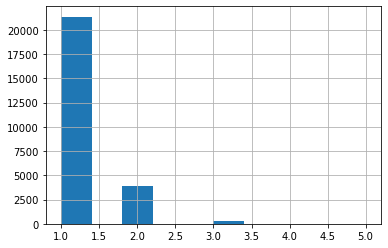

In [10]:
df_base[base_genres].sum(axis=1).hist()

#### Replicating identified subgenre information from Danny's EDA

Note that these tracks are those that are not already tagged as being in any of our base genres.  So, for example, if a track is tagged as `rock` and also `rocknroll` it is captured above and not reflected here.  On the other hand, if a track is tagged as `rocknroll` but not otherwise tagged as being in one of our base genres, it is reflected here.  So, any mapping we do with this set into the base groups will be effective to enlarge the base groups.

In [11]:
df[subgenres].sum(axis=0).sort_values(ascending=False)

genre_orchestral          2432
genre_poprock             2172
genre_instrumentalpop     1477
genre_rap                  993
genre_punkrock             729
genre_symphonic            712
genre_instrumentalrock     598
genre_hardrock             490
genre_grunge               375
genre_rocknroll            342
genre_acidjazz             304
genre_heavymetal           222
genre_classicrock          222
genre_jazzfusion           221
genre_alternativerock      215
dtype: int64

#### Continuing EDA after removing any tracks in either the base or identified subgenre collections

This analysis continues by looking at the set of tracks in the `unidentified_genres` set after removing from consideration any tracks in either the base set or identified subgenre set.

In [12]:
df_base_and_subgenres_excluded = df[df[base_genres + subgenres].sum(axis=1) == 0]

If we built this dataframe correctly, none of the tracks should have `base` or `identified_subgenres` tags.

In [13]:
temp = df_base_and_subgenres_excluded.sum(axis=0)
temp[temp == 0]

genre_acidjazz            0
genre_alternativerock     0
genre_blues               0
genre_classical           0
genre_classicrock         0
genre_country             0
genre_disco               0
genre_grunge              0
genre_hardrock            0
genre_heavymetal          0
genre_hiphop              0
genre_instrumentalpop     0
genre_instrumentalrock    0
genre_jazz                0
genre_jazzfusion          0
genre_metal               0
genre_orchestral          0
genre_pop                 0
genre_poprock             0
genre_punkrock            0
genre_rap                 0
genre_reggae              0
genre_rock                0
genre_rocknroll           0
genre_symphonic           0
dtype: int64

It looks like we have excluded tracks that are in the base or identified_subgenre groups from the set as we hoped.  Now lets focus on the distribution of unidentified_genre tracks in what remains.

In [14]:
df_base_and_subgenres_excluded[unidentified_genres].sum(axis=0)

genre_alternative    1767
genre_dance          2059
genre_indie           758
genre_folk           1120
genre_popfolk         691
genre_triphop         692
genre_funk            398
genre_rnb             154
genre_soul            139
genre_ska              58
genre_groove           84
genre_jazzfunk         68
genre_swing            40
genre_bossanova        54
genre_bluesrock         3
dtype: int64

### Techniques for Working With Our One Hot Encoded Classes

Here are some simple techniques we can uses to convert from sparse to dense genre encodings and to get a label for a genre from a dense encoding.

The numpy argmax function can be used to identify the index in a cluster of one hot encoded columns where the 1 value appears.  If two columns have a 1 in them the function will return the first such column index.  We will likely want to avoid this with data preprocessing.

Here are the dense encodings for the first fifteen tracks in base genres.  I'm not sure how to do this directly in pandas so I convert the data frame to a numpy array first.

In [67]:
some_dense_encodings = np.argmax(df_base[base_genres].to_numpy(), axis=1)[:15]
display(some_dense_encodings)

array([1, 9, 1, 5, 9, 5, 1, 7, 8, 9, 7, 1, 1, 7, 5])

Here are the one hot encodings for the same first fifteen tracks.

In [65]:
df_base[base_genres][:15]

,genre_blues,genre_classical,genre_country,genre_disco,genre_hiphop,genre_jazz,genre_metal,genre_pop,genre_reggae,genre_rock
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1
11,0,0,0,0,0,1,0,0,0,0
12,0,1,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,1,0,0
16,0,0,0,0,0,0,0,0,1,0
19,0,0,0,0,0,0,0,0,0,1


And finally, a simple list comprehension to assemble a list of labels for those dense encodings.

In [68]:
[base_genres[index] for index in some_dense_encodings]

['genre_classical',
 'genre_rock',
 'genre_classical',
 'genre_jazz',
 'genre_rock',
 'genre_jazz',
 'genre_classical',
 'genre_pop',
 'genre_reggae',
 'genre_rock',
 'genre_pop',
 'genre_classical',
 'genre_classical',
 'genre_pop',
 'genre_jazz']